### Example Implementation
This file goes through every step of the process, using features available to HotDeckImputer.

In [1]:
# from hot_deck_imputer import HotDeckImputer
# Add the src directory to the Python path
import sys
import os

# Import the HotDeckImputer class
from hot_deck_imputer import HotDeckImputer
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#### Generate Data

In [2]:
# Create possibilities for race, sex, and work
race_categories = ['Black', 'White', 'Asian']
sex_categories = ['M', 'F']
work_categories = [0, 1]

np.random.seed(42)  # For reproducibility
values = np.arange(0, 100001, 10000)  # Generates [0, 10000, ..., 100000] to reflect discrete asset values

# Generate polars frames
donor_data = {
    'id': np.arange(1000),  # Unique donor IDs
    'donor_assets': np.random.choice(values, size=1000, replace=True),
    'race_cell': np.random.choice(race_categories, size=1000),
    'sex_cell': np.random.choice(sex_categories, size=1000),
    'work_cell': np.random.choice(work_categories, size=1000),
    'weight': np.random.randint(1, 5, size=1000)
}

donor_data = pl.DataFrame(donor_data)

recipient_data = {
    'id': np.arange(1500),  # Unique recipient IDs
    'race_cell': np.random.choice(race_categories, size=1500),
    'sex_cell': np.random.choice(sex_categories, size=1500),
    'work_cell': np.random.choice(work_categories, size=1500),
    'weight': np.random.randint(1, 5, size=1500)
}

recipient_data = pl.DataFrame(recipient_data)

#### Create Imputer + Define Cells

In [3]:
imputer = HotDeckImputer(donor_data = donor_data, 
                         imputation_var = 'donor_assets', 
                         weight_var = 'weight', 
                         recipient_data = recipient_data,
                         random_seed = 42)

In [4]:
# If you are imputing from one dataset to another across years, this will adjust the donor data to the recipient year
imputer.age_dollar_amounts(donor_year_cpi = 223.1, imp_year_cpi = 322.1)

Summary of donor_assets pre CPI aging:
{'mean': 48400.0, 'median': 50000.0, 'min': 0, 'max': 100000, 'std_dev': 31585.40228709518, 'count': 1000, 'missing_values': 0}
Summary of donor_assets post CPI aging:
{'mean': 69877.36441057822, 'median': 72187.35992828329, 'min': 0.0, 'max': 144374.71985656657, 'std_dev': 45601.33606756324, 'count': 1000, 'missing_values': 0}


In [5]:
# The variables create cells held in imputer.donor_cells, a dictionary.
# These cells divide the data according to every unique combination of the variables. 
# Key: combination of variables defining cell, Value: pl.DataFrame of data in that cell
variables = ['race_cell','sex_cell']

imputer.define_cells(variables)

# Take a look at cell definitions
imputer.cell_definitions

["race_cell == 'Asian' & sex_cell == 'F'",
 "race_cell == 'Asian' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'F'",
 "race_cell == 'White' & sex_cell == 'M'",
 "race_cell == 'Black' & sex_cell == 'F'",
 "race_cell == 'Black' & sex_cell == 'M'"]

In [6]:
# Create the cells after defining them, assuming above looks right
imputer.generate_cells()

In [7]:
# Take a look at the recipient cells
imputer.recipient_cells

{"race_cell == 'Asian' & sex_cell == 'F'": shape: (247, 5)
 ┌──────┬───────────┬──────────┬───────────┬────────┐
 │ id   ┆ race_cell ┆ sex_cell ┆ work_cell ┆ weight │
 │ ---  ┆ ---       ┆ ---      ┆ ---       ┆ ---    │
 │ i32  ┆ str       ┆ str      ┆ i32       ┆ i32    │
 ╞══════╪═══════════╪══════════╪═══════════╪════════╡
 │ 6    ┆ Asian     ┆ F        ┆ 1         ┆ 4      │
 │ 11   ┆ Asian     ┆ F        ┆ 0         ┆ 3      │
 │ 25   ┆ Asian     ┆ F        ┆ 0         ┆ 4      │
 │ 30   ┆ Asian     ┆ F        ┆ 0         ┆ 4      │
 │ 32   ┆ Asian     ┆ F        ┆ 0         ┆ 2      │
 │ …    ┆ …         ┆ …        ┆ …         ┆ …      │
 │ 1478 ┆ Asian     ┆ F        ┆ 1         ┆ 1      │
 │ 1481 ┆ Asian     ┆ F        ┆ 0         ┆ 2      │
 │ 1488 ┆ Asian     ┆ F        ┆ 1         ┆ 2      │
 │ 1489 ┆ Asian     ┆ F        ┆ 1         ┆ 2      │
 │ 1493 ┆ Asian     ┆ F        ┆ 1         ┆ 2      │
 └──────┴───────────┴──────────┴───────────┴────────┘,
 "race_cell == 'Asian'

In [8]:
# Take a look at donor cells
imputer.donor_cells

{"race_cell == 'Asian' & sex_cell == 'F'": shape: (174, 6)
 ┌─────┬───────────────┬───────────┬──────────┬───────────┬────────┐
 │ id  ┆ donor_assets  ┆ race_cell ┆ sex_cell ┆ work_cell ┆ weight │
 │ --- ┆ ---           ┆ ---       ┆ ---      ┆ ---       ┆ ---    │
 │ i32 ┆ f64           ┆ str       ┆ str      ┆ i32       ┆ i32    │
 ╞═════╪═══════════════╪═══════════╪══════════╪═══════════╪════════╡
 │ 0   ┆ 86624.831914  ┆ Asian     ┆ F        ┆ 1         ┆ 4      │
 │ 2   ┆ 144374.719857 ┆ Asian     ┆ F        ┆ 1         ┆ 3      │
 │ 6   ┆ 129937.247871 ┆ Asian     ┆ F        ┆ 0         ┆ 1      │
 │ 7   ┆ 28874.943971  ┆ Asian     ┆ F        ┆ 1         ┆ 1      │
 │ 14  ┆ 101062.3039   ┆ Asian     ┆ F        ┆ 1         ┆ 2      │
 │ …   ┆ …             ┆ …         ┆ …        ┆ …         ┆ …      │
 │ 978 ┆ 28874.943971  ┆ Asian     ┆ F        ┆ 0         ┆ 4      │
 │ 988 ┆ 57749.887943  ┆ Asian     ┆ F        ┆ 1         ┆ 3      │
 │ 996 ┆ 115499.775885 ┆ Asian     ┆ F      

In [9]:
# After deciding that you want to split on work_cell for Black Women, you can do the following
imputer.split_cell("race_cell == 'Black' & sex_cell == 'F'", "work_cell")
imputer.split_cell("race_cell == 'White' & sex_cell == 'F'", "work_cell")


Cell splitting completed successfully.
To rerun with these cells submit imputer.impute() again.
Cell splitting completed successfully.
To rerun with these cells submit imputer.impute() again.


In [10]:
# Cell definitions have changed, as have donor cells
imputer.cell_definitions

["race_cell == 'Asian' & sex_cell == 'F'",
 "race_cell == 'Asian' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'M'",
 "race_cell == 'Black' & sex_cell == 'M'",
 "race_cell == 'Black' & sex_cell == 'F' & work_cell == 1",
 "race_cell == 'Black' & sex_cell == 'F' & work_cell == 0",
 "race_cell == 'White' & sex_cell == 'F' & work_cell == 0",
 "race_cell == 'White' & sex_cell == 'F' & work_cell == 1"]

In [11]:
# Take a look at donor and recipient after splitting
imputer.donor_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 1"]

id,donor_assets,race_cell,sex_cell,work_cell,weight
i32,f64,str,str,i32,i32
5,86624.831914,"""Black""","""F""",1,4
12,57749.887943,"""Black""","""F""",1,2
17,72187.359928,"""Black""","""F""",1,3
42,86624.831914,"""Black""","""F""",1,2
47,129937.247871,"""Black""","""F""",1,3
…,…,…,…,…,…
956,101062.3039,"""Black""","""F""",1,3
958,43312.415957,"""Black""","""F""",1,3
971,14437.471986,"""Black""","""F""",1,4


In [12]:
imputer.recipient_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 1"]

id,race_cell,sex_cell,work_cell,weight
i32,str,str,i32,i32
13,"""Black""","""F""",1,3
15,"""Black""","""F""",1,2
21,"""Black""","""F""",1,1
45,"""Black""","""F""",1,4
50,"""Black""","""F""",1,3
…,…,…,…,…
1418,"""Black""","""F""",1,3
1438,"""Black""","""F""",1,3
1441,"""Black""","""F""",1,2


In [13]:
imputer.recipient_cells["race_cell == 'Black' & sex_cell == 'F' & work_cell == 0"]

id,race_cell,sex_cell,work_cell,weight
i32,str,str,i32,i32
4,"""Black""","""F""",0,2
10,"""Black""","""F""",0,3
16,"""Black""","""F""",0,4
17,"""Black""","""F""",0,3
22,"""Black""","""F""",0,2
…,…,…,…,…
1456,"""Black""","""F""",0,2
1457,"""Black""","""F""",0,1
1461,"""Black""","""F""",0,3


In [14]:
# Collapse cell for White and Black folks back to original, without work
imputer.collapse_cell("race_cell == 'Black' & sex_cell == 'F'")
imputer.collapse_cell("race_cell == 'Black' & sex_cell == 'M'")
imputer.collapse_cell("race_cell == 'White' & sex_cell == 'F'")
imputer.collapse_cell("race_cell == 'White' & sex_cell == 'M'")

imputer.cell_definitions

Cell collapsing completed successfully.
To rerun with these cells submit imputer.impute() again.
Cell collapsing completed successfully.
To rerun with these cells submit imputer.impute() again.
Cell collapsing completed successfully.
To rerun with these cells submit imputer.impute() again.
Cell collapsing completed successfully.
To rerun with these cells submit imputer.impute() again.


["race_cell == 'Asian' & sex_cell == 'F'",
 "race_cell == 'Asian' & sex_cell == 'M'",
 "race_cell == 'Black' & sex_cell == 'F'",
 "race_cell == 'Black' & sex_cell == 'M'",
 "race_cell == 'White' & sex_cell == 'F'",
 "race_cell == 'White' & sex_cell == 'M'"]

#### Impute Data + Apply Smoothing

In [15]:
imputer.impute()

In [16]:
# Notice imp_donor_assets has been added to recipient cells
imputer.recipient_cells

{"race_cell == 'Asian' & sex_cell == 'F'": shape: (247, 6)
 ┌──────┬───────────┬──────────┬───────────┬────────┬──────────────────┐
 │ id   ┆ race_cell ┆ sex_cell ┆ work_cell ┆ weight ┆ imp_donor_assets │
 │ ---  ┆ ---       ┆ ---      ┆ ---       ┆ ---    ┆ ---              │
 │ i32  ┆ str       ┆ str      ┆ i32       ┆ i32    ┆ f64              │
 ╞══════╪═══════════╪══════════╪═══════════╪════════╪══════════════════╡
 │ 6    ┆ Asian     ┆ F        ┆ 1         ┆ 4      ┆ 129937.247871    │
 │ 11   ┆ Asian     ┆ F        ┆ 0         ┆ 3      ┆ 0.0              │
 │ 25   ┆ Asian     ┆ F        ┆ 0         ┆ 4      ┆ 129937.247871    │
 │ 30   ┆ Asian     ┆ F        ┆ 0         ┆ 4      ┆ 43312.415957     │
 │ 32   ┆ Asian     ┆ F        ┆ 0         ┆ 2      ┆ 72187.359928     │
 │ …    ┆ …         ┆ …        ┆ …         ┆ …      ┆ …                │
 │ 1478 ┆ Asian     ┆ F        ┆ 1         ┆ 1      ┆ 115499.775885    │
 │ 1481 ┆ Asian     ┆ F        ┆ 0         ┆ 2      ┆ 129937.2478

In [17]:
imputer.recipient_data

id,race_cell,sex_cell,work_cell,weight,imp_donor_assets
i32,str,str,i32,i32,f64
6,"""Asian""","""F""",1,4,129937.247871
11,"""Asian""","""F""",0,3,0.0
25,"""Asian""","""F""",0,4,129937.247871
30,"""Asian""","""F""",0,4,43312.415957
32,"""Asian""","""F""",0,2,72187.359928
…,…,…,…,…,…
1472,"""White""","""M""",1,3,14437.471986
1474,"""White""","""M""",0,3,115499.775885
1479,"""White""","""M""",0,2,129937.247871


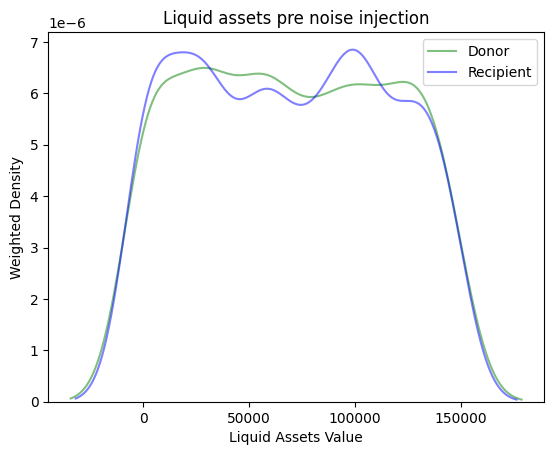

In [18]:
# Compare the input to the output in the process
plot_data = imputer.recipient_data[['weight','imp_donor_assets']].to_pandas()
plot_data_donor = imputer.donor_data[['weight','donor_assets']].to_pandas()

# Create a weighted histogram plot for donor data
sns.kdeplot(data=plot_data_donor, x='donor_assets', weights='weight', color='green', label='Donor', alpha=0.5)

# Create a weighted histogram plot for recipient data
sns.kdeplot(data=plot_data, x='imp_donor_assets', weights='weight', color='blue', label='Recipient', alpha=0.5)

# Add titles and labels
plt.title('Liquid assets pre noise injection')
plt.xlabel('Liquid Assets Value')
plt.ylabel('Weighted Density')

# Add a legend to differentiate between recipient and donor data
plt.legend()

# Show the plot
plt.show()

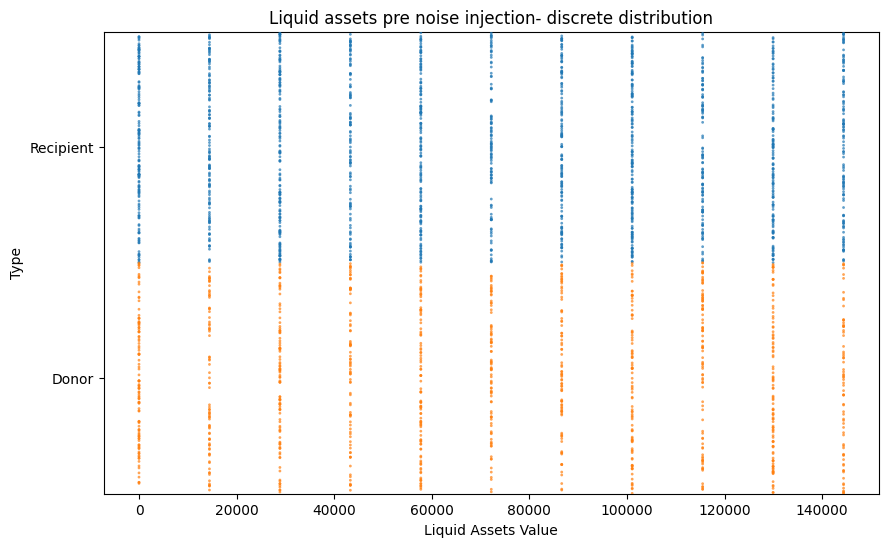

In [19]:
# Compare the input to the output in the process
plot_data['Type'] = 'Recipient'  # Add a column to differentiate types
plot_data_donor['Type'] = 'Donor'  # Add a column to differentiate types

# Combine the two datasets for plotting
plot_data_combined = pd.concat([
    plot_data.rename(columns={'imp_donor_assets': 'Assets'}),
    plot_data_donor.rename(columns={'donor_assets': 'Assets'})
], ignore_index=True)

# Create a swarmplot
plt.figure(figsize=(10, 6))
sns.stripplot(data=plot_data_combined, x='Assets', y='Type', hue='Type', alpha=0.7, jitter=0.5, size = 2)

# Add titles and labels
plt.title('Liquid assets pre noise injection- discrete distribution')
plt.xlabel('Liquid Assets Value')
plt.ylabel('Type')

# Show the plot
plt.show()

**Methodological note**: variation_stdev is a multiplier, used in the following way:

- Mean distances between donors' nearest neighbors, within each cell, are computed.
- A normal distribution is defined:
    - With a mean of 0.
    - And with a standard deviation obtained by multiplying mean distances by variation_stdev.
- Then the resulting noise (positive or negative), defined by that normal distribution, is added to existing imputed values.
    
    
This defines noise for **each cell** according to the variation within that cell's source data. If a cell has large distances between neighbors, the noise applied gets larger. In the case of asset imputation this feature can be useful. For example, if people who are not working have relatively low asset values in source data (this is not observable in this toy example), you would not necessarily want to add noise that could inflate assets reflective of large variation among those who are working. The scalar multiplier added in variation_stddev applies to every cell, but will be modulated by the distribution present in source data. That allows a user to better control noise.

In [20]:
imputer.recipient_data.filter(pl.col('id') == 2)

id,race_cell,sex_cell,work_cell,weight,imp_donor_assets
i32,str,str,i32,i32,f64
2,"""Asian""","""M""",0,3,101062.3039


In [21]:
# To smooth out clusters, you can add random noise proportional to the standard deviation of the variable 
# and set a floor value that the noise cannot send a value below (to avoid negative or impossible values)
imputer.apply_random_noise(variation_stdev = 3, floor_noise = 1.5)

In [22]:
imputer.recipient_data.filter(pl.col('id') == 2)

id,race_cell,sex_cell,work_cell,weight,imp_donor_assets
i32,str,str,i32,i32,f64
2,"""Asian""","""M""",0,3,104440.014088


In [23]:
# Take a look at the random noise used, initialized after above function is called
imputer.random_noise

3

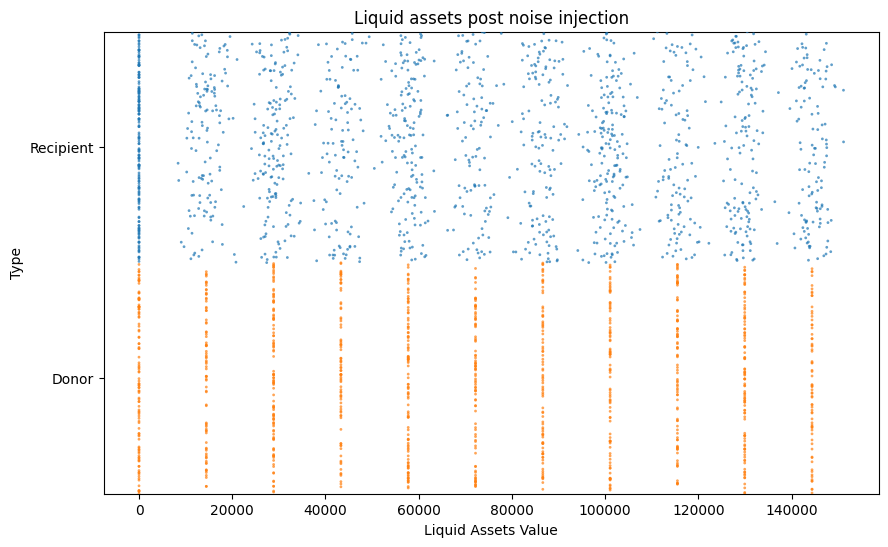

In [24]:
# Compare the input to the output in the process
plot_data = imputer.recipient_data[['weight','imp_donor_assets']].to_pandas()
plot_data_donor = imputer.donor_data[['weight','donor_assets']].to_pandas()

# Compare the input to the output in the process
plot_data['Type'] = 'Recipient'  # Add a column to differentiate types
plot_data_donor['Type'] = 'Donor'  # Add a column to differentiate types

# Combine the two datasets for plotting
plot_data_combined = pd.concat([
    plot_data.rename(columns={'imp_donor_assets': 'Assets'}),
    plot_data_donor.rename(columns={'donor_assets': 'Assets'})
], ignore_index=True)

# Create a swarmplot
plt.figure(figsize=(10, 6))
sns.stripplot(data=plot_data_combined, x='Assets', y='Type', hue='Type', alpha=0.7, jitter=0.5, size = 2)

# Add titles and labels
plt.title('Liquid assets post noise injection')
plt.xlabel('Liquid Assets Value')
plt.ylabel('Type')

# Show the plot
plt.show()

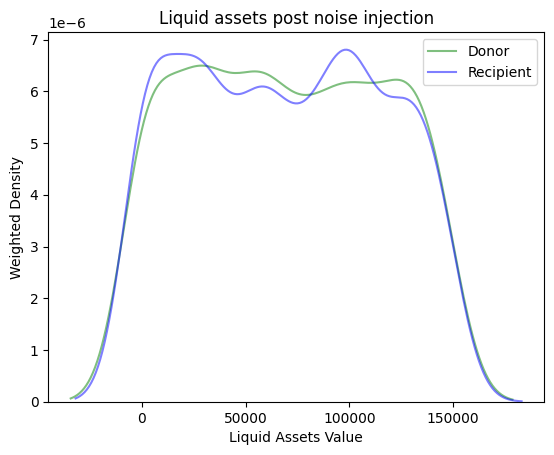

In [29]:
# Create a weighted histogram plot for donor data
sns.kdeplot(data=plot_data_donor, x='donor_assets', weights='weight', color='green', label='Donor', alpha=0.5)

# Create a weighted histogram plot for recipient data
sns.kdeplot(data=plot_data, x='imp_donor_assets', weights='weight', color='blue', label='Recipient', alpha=0.5)

# Add titles and labels
plt.title('Liquid assets post noise injection')
plt.xlabel('Liquid Assets Value')
plt.ylabel('Weighted Density')

# Add a legend to differentiate between recipient and donor data
plt.legend()

# Show the plot
plt.show()

#### Examine Results

In [25]:
imputer.donor_data.columns

['id', 'donor_assets', 'race_cell', 'sex_cell', 'work_cell', 'weight']

In [26]:
imputer.summarize_column(imputer.donor_data, 'donor_assets')

{'mean': 69877.36441057822,
 'median': 72187.35992828329,
 'min': 0.0,
 'max': 144374.71985656657,
 'std_dev': 45601.33606756324,
 'count': 1000,
 'missing_values': 0}

In [27]:
imputer.summarize_column(imputer.recipient_data, 'imp_donor_assets')

{'mean': 69726.98645769648,
 'median': 70194.10223959979,
 'min': 0.0,
 'max': 151135.16911865916,
 'std_dev': 46056.25941896097,
 'count': 1500,
 'missing_values': 0}

In [28]:
imputer.gen_analysis_file('hot_deck_stats', '')

Cell data written to '.\hot_deck_stats.xlsx'.
